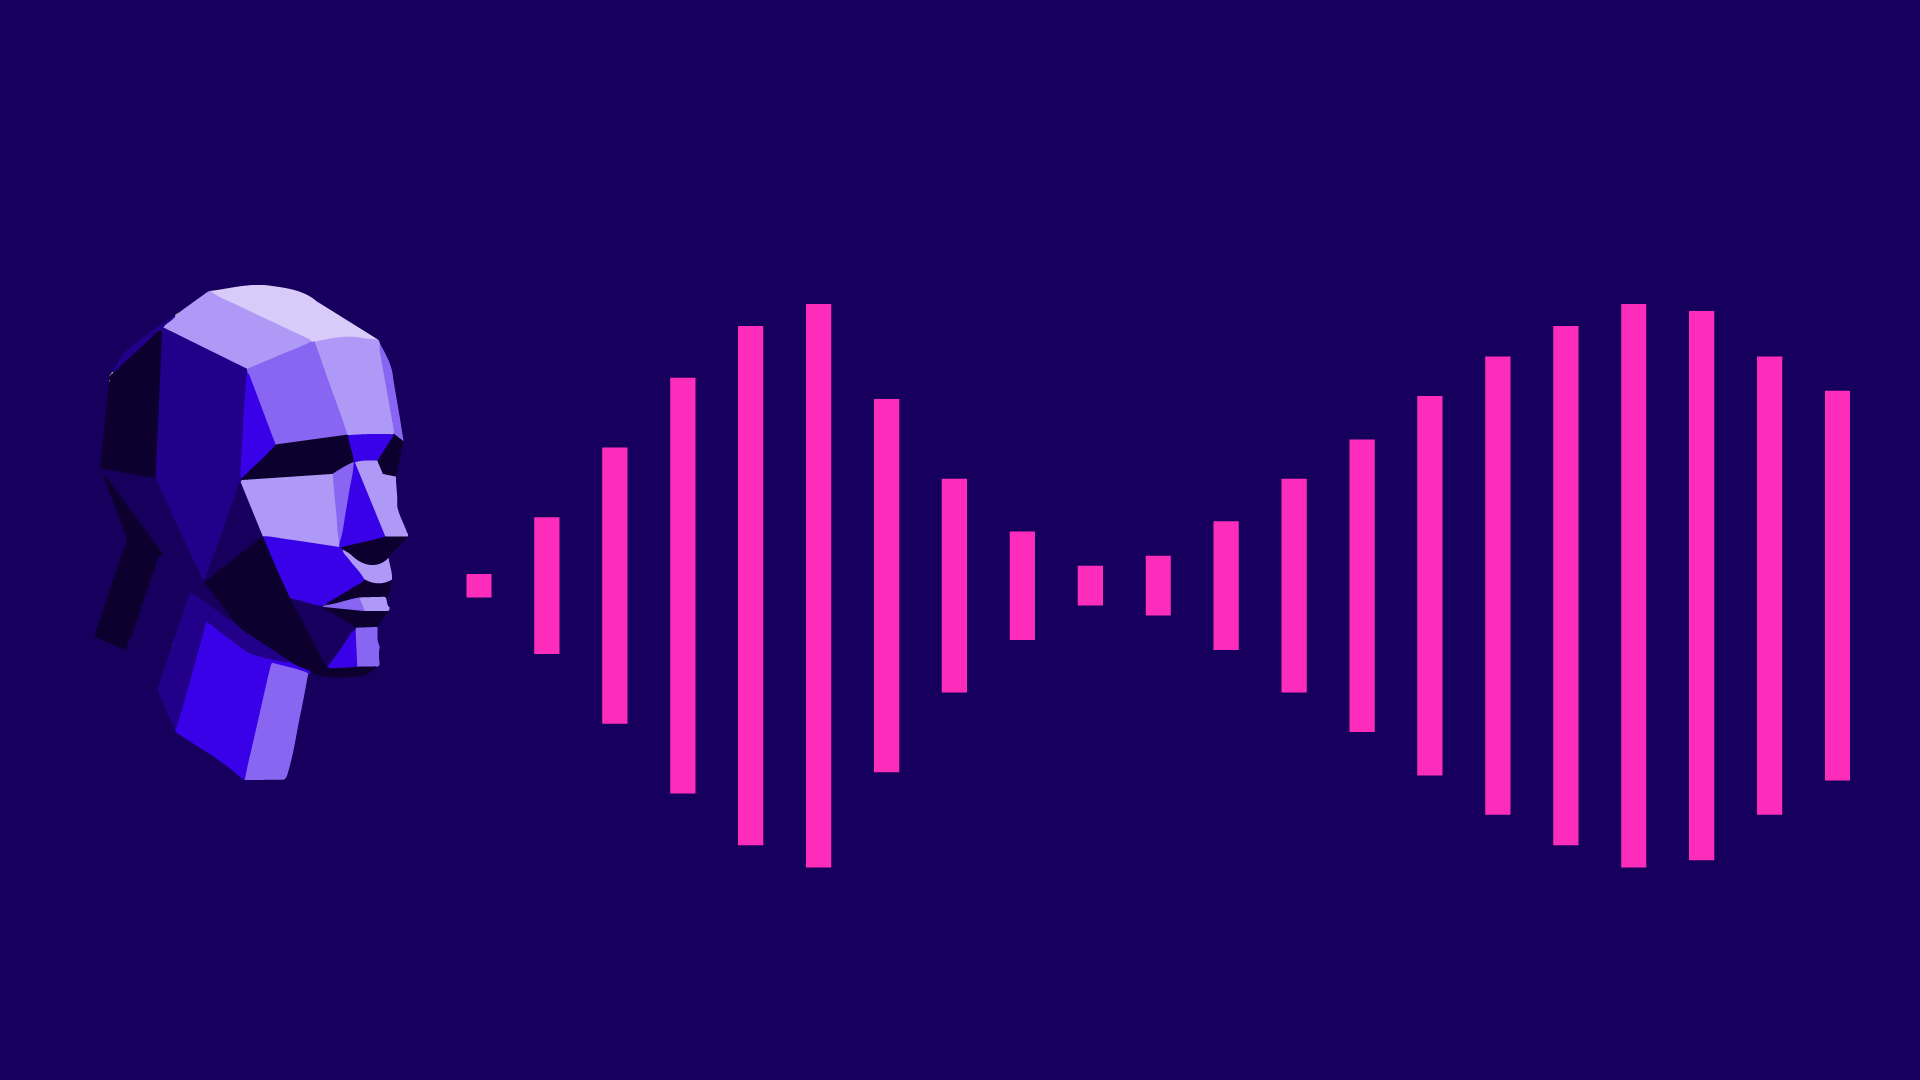

# Speech Recognition Through Spectrograms - ARI

Spectrograms provide a visual representation of the frequency content over time, which is useful for capturing the spectral characteristics of speech.

In [7]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# LOAD AUDIO

load_audio_files() takes a file path and a label as inputs. It reads WAV audio files from the specified path, extracting information. Using torchaudio for audio loading, the function organizes these details into a list, making it useful for tasks such as speech recognition or classification.

In [74]:
def load_audio_files(path: str, label:str):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
    return dataset

In [ ]:
trainset_speechcommands_tree = load_audio_files('/kaggle/working/SpeechCommands/speech_commands_v0.02/tree', 'tree')
trainset_speechcommands_cat = load_audio_files('/kaggle/working/SpeechCommands/speech_commands_v0.02/cat', 'cat')

In [11]:
print(f'Length of yes dataset: {len(trainset_speechcommands_tree)}')
print(f'Length of no dataset: {len(trainset_speechcommands_cat)}')

Length of yes dataset: 4044
Length of no dataset: 3941


# DATALOADERS

In [13]:
trainloader_tree = torch.utils.data.DataLoader(trainset_speechcommands_tree, batch_size=1,
                                            shuffle=True, num_workers=0)
trainloader_cat = torch.utils.data.DataLoader(trainset_speechcommands_cat, batch_size=1,
                                            shuffle=True, num_workers=0)

# WAVEFORMS

A waveform refers to the graphical representation of sound signal. It depicts how the air pressure varies over time.

In [15]:
def show_waveform(waveform, sample_rate, label):
    print("Waveform: {}\nSample rate: {}\nLabels: {} \n".format(waveform, sample_rate, label))
    new_sample_rate = sample_rate/10
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))
    print("Shape of transformed waveform: {}\nSample rate: {}".format(waveform_transformed.size(), new_sample_rate))
    plt.figure()
    plt.plot(waveform_transformed[0,:].numpy())

In [ ]:
cat_waveform = trainset_speechcommands_cat[0][0]
cat_sample_rate = trainset_speechcommands_cat[0][1]
tree_waveform = trainset_speechcommands_tree[0][0]
tree_sample_rate = trainset_speechcommands_tree[0][1]

Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Sample rate: 16000
Labels: yes 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


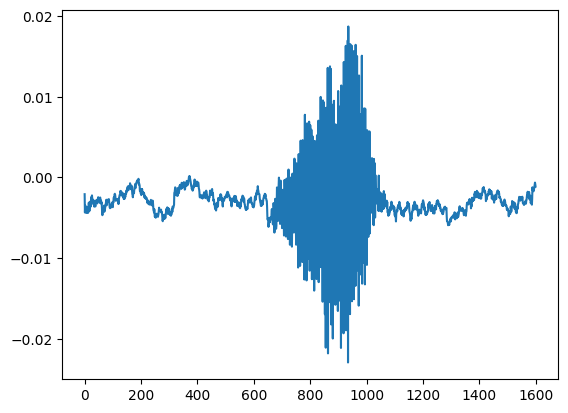

In [16]:
show_waveform(cat_waveform, cat_sample_rate, 'cat')

# SPECTROGRAM

A spectrogram is a visual representation of the frequency content of a signal as it varies with time.

In [18]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))    
    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('no'))
    plt.imshow(yes_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('yes'))
    plt.imshow(no_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')  


Shape of yes spectrogram: torch.Size([1, 201, 81])
Shape of no spectrogram: torch.Size([1, 201, 81])


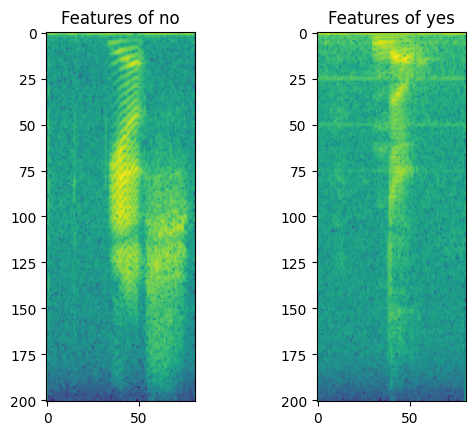

In [19]:
show_spectrogram(cat_waveform, tree_waveform)

# MELSPECTROGRAM

A Mel spectrogram is a specialized representation of the frequency content of an audio signal, designed to mimic human auditory perception. It is obtained by applying the Mel filterbank to the power spectrum of short, overlapping frames of the signal. 

In [20]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))
    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 81])


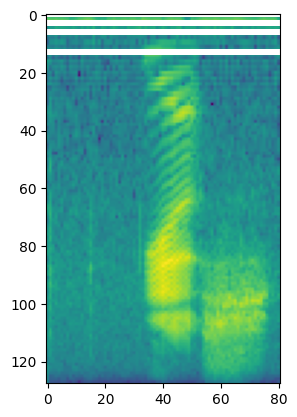

In [25]:
show_melspectrogram(cat_waveform, cat_sample_rate)

# Mel-Frequency Cepstral Coefficients

MFCCs are derived from the Mel spectrogram and represent the spectral characteristics of an audio signal in a way that is more perceptually relevant to human hearing.

In [22]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
    plt.draw()

Shape of spectrogram: torch.Size([1, 40, 81])


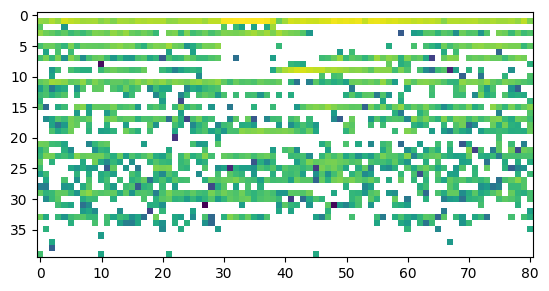

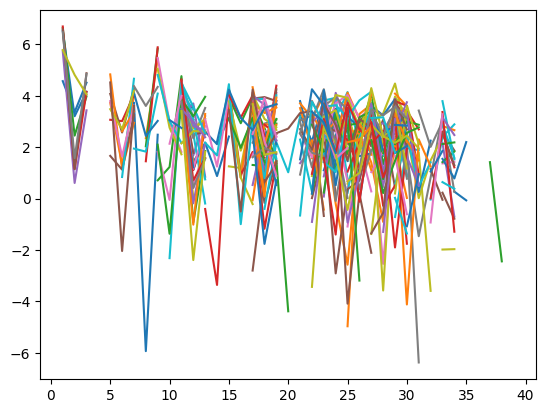

In [23]:
show_mfcc(cat_waveform,  cat_sample_rate)

# CREATE SPECTROGRAM IMAGES IN IMAGEFOLDER

In [101]:
def create_spectrogram_images(trainloader, label_dir):
    directory = f'/kaggle/working/spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        for i, data in enumerate(trainloader):
            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]
            ID = data[3]
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)     
            fig = plt.figure()
            plt.imsave(f'/kaggle/working/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='viridis')

In [102]:
create_spectrogram_images(trainloader_yes, 'tree')
create_spectrogram_images(trainloader_no, 'cat')

Data exists for tree
Data exists for cat


In [104]:
data_path = '/kaggle/working/spectrograms' #looking in subfolder train

tree_cat_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,81)),
                                  transforms.ToTensor()
                                  ])
)
print(tree_cat_dataset)

Dataset ImageFolder
    Number of datapoints: 7985
    Root location: /kaggle/working/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [105]:
class_map=tree_cat_dataset.class_to_idx
print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'cat': 0, 'tree': 1}



In [106]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(tree_cat_dataset))
test_size = len(tree_cat_dataset) - train_size
tree_cat_dataset, tree_cat_test_dataset = torch.utils.data.random_split(tree_cat_dataset, [train_size, test_size])

print("Training size:", len(tree_cat_dataset))
print("Testing size:",len(tree_cat_test_dataset))

Training size: 6388
Testing size: 1597


In [92]:
from collections import Counter
# labels in training set
train_classes = [label for _, label in tree_cat_dataset]
Counter(train_classes)

Counter({1: 3228, 0: 3160})

In [107]:
train_dataloader = torch.utils.data.DataLoader(
    tree_cat_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    tree_cat_test_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CNN

Spectrogram images capture the frequency content of the audio over time. The CNN trained on a dataset of these spectrogram images, learning to recognize patterns and features that correspond to different speech elements. Once trained, the model can take new spectrogram images and predict the corresponding speech transcription. This approach leverages the power of CNNs to automatically learn relevant features from the spectrogram data, contributing to effective speech recognition models.

In [110]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)

In [111]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function
def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

# TRAIN

In [112]:
epochs = 15
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.691589  [    0/ 6388]
loss: 0.598309  [ 1500/ 6388]
loss: 0.447526  [ 3000/ 6388]
loss: 0.327089  [ 4500/ 6388]
loss: 0.514054  [ 6000/ 6388]

Test Error:
acc: 90.4%, avg loss: 0.014237

Epoch 2
-------------------------------
loss: 0.193911  [    0/ 6388]
loss: 0.630975  [ 1500/ 6388]
loss: 0.125997  [ 3000/ 6388]
loss: 0.291822  [ 4500/ 6388]
loss: 0.332345  [ 6000/ 6388]

Test Error:
acc: 91.7%, avg loss: 0.011888

Epoch 3
-------------------------------
loss: 0.155943  [    0/ 6388]
loss: 0.198540  [ 1500/ 6388]
loss: 0.067750  [ 3000/ 6388]
loss: 0.247625  [ 4500/ 6388]
loss: 0.286164  [ 6000/ 6388]

Test Error:
acc: 93.1%, avg loss: 0.009812

Epoch 4
-------------------------------
loss: 0.101816  [    0/ 6388]
loss: 0.112387  [ 1500/ 6388]
loss: 0.025712  [ 3000/ 6388]
loss: 0.115893  [ 4500/ 6388]
loss: 0.155643  [ 6000/ 6388]

Test Error:
acc: 94.3%, avg loss: 0.009119

Epoch 5
-------------------------------
loss: 0.199169  [   

# TEST

In [128]:
model.eval()
test_loss, correct = 0, 0
class_map = ['cat', 'tree']
correct=0
total = 0
with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        total+=1
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        if Y[0] == pred[0].argmax(0):
            correct+=1
print(correct/total)

0.9345794392523364
